#Imports

In [1]:
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 8.3 MB/s 


In [2]:
import numpy as np
import pandas as pd
import igraph as ig
from igraph import Graph
import json
import csv
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay
from copy import deepcopy
from sklearn.metrics.pairwise import euclidean_distances
import time

# Set up


In [3]:
with open('los_angeles_censustracts.json') as f:
    census_tracts = json.loads(f.readline())

In [4]:
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [5]:
for i in range(5):
    key = i + 1
    print(f'{key}: {display_names[key]}, {coordinates[key]}')

1: Census Tract 480302, [-118.12053321   34.10309557]
2: Census Tract 480303, [-118.13785063   34.09645121]
3: Census Tract 480304, [-118.13138209   34.09626386]
4: Census Tract 480400, [-118.13224544   34.10349303]
5: Census Tract 480500, [-118.14492317   34.0986815 ]


In [6]:
g = Graph(directed=False)
g.add_vertices(len(display_names))
g.vs['display_name'] = list(display_names.values())  # index = id - 1
g.vs['coordinates'] = list(coordinates.values())

In [7]:
edges = []
weights = []

# graph.txt only contains December data. For faster loading
with open('graph.txt') as f:
    
    while True:
        line = f.readline()
        if line == '':
            break  # end of file
        
        vals = line.strip().split(' ')
        
        # read edge info
        src, dest, dist = int(vals[0]), int(vals[1]), float(vals[2])
            
        edges.append((src - 1, dest - 1))
        weights.append(dist)

In [8]:
# month_filter = {12}  # for monthly aggregate data of 4th quarter, we can filter data based off of only December

# edges = []
# weights = []

# with open('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv') as f:
#     f.readline()  # skip the first line
    
#     while True:
#         line = f.readline()
#         if line == '':
#             break  # end of file
        
#         vals = line.strip().split(',')
        
#         # read edge info
#         src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])

#         # if data is not relevant, skip it
#         if month not in month_filter:
#             continue
            
#         edges.append((src - 1, dest - 1))
#         weights.append(dist)

In [9]:
g.add_edges(edges)
g.es['weight'] = weights

In [10]:
# keep only the giant connected component
components = g.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g.vs)) if i not in gcc]
g.delete_vertices(vs_to_delete)

# remove duplicate edges
g = g.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges

In [11]:
print(len(g.vs), len(g.es))

2649 1003858


In [12]:
lons = []
lats = []
for coordinate in g.vs['coordinates']:
    lats.append(coordinate[0])
    lons.append(coordinate[1])

In [13]:
map_bound = ((-118.75, -117.75, 33.45, 34.45))
figsize = (14.56,17.60)
def mapping(lon, lat, z=None, fig_size = figsize, boundary=map_bound, real_map='LA.png',title='Title', save=False,name=None, plot_point=None):
    fig, ax = plt.subplots(figsize = fig_size)
    if z:
        plt.triplot(lon, lat, z)
    else:
        ax.plot(lons,lats,color='purple',markersize=2,marker='*',markerfacecolor='blue')
    if plot_point:
        plt.plot(plot_point[0],plot_point[1],'k.',ms=20)
    ax.set_title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Lattitude')
    ax.set_xlim(boundary[0],boundary[1])
    ax.set_ylim(boundary[2],boundary[3])
    if real_map != '':
        ax.imshow(plt.imread(real_map), zorder=0, extent = boundary, aspect= 'equal')
    if save:
        plt.savefig('{}.png'.format(name))
    plt.show()

### Delaunay triangulation

In [14]:
tri = Delaunay(g.vs['coordinates'])

In [15]:
tri_list = []
for s in tri.simplices.copy():
    tri_list.append(s)

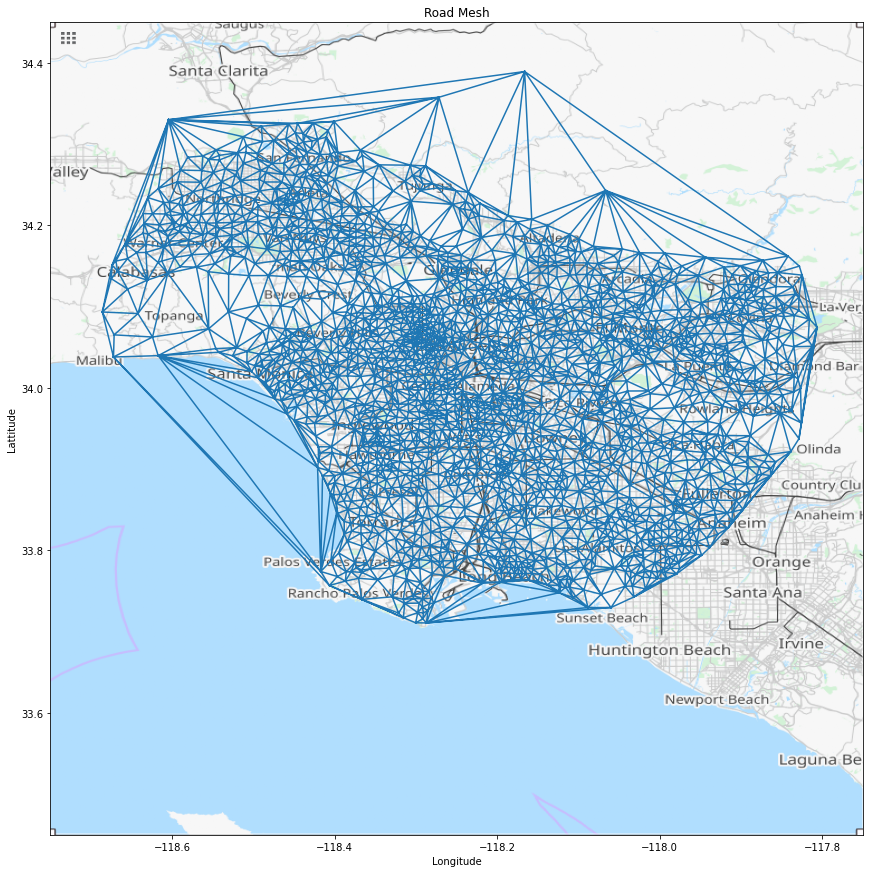

In [16]:
mapping(lats, lons, z=tri_list, title='Road Mesh')

In [17]:
g1 = deepcopy(g)

In [18]:
edges_to_induce = []

for i in range(tri.simplices.shape[0]):
    for col1, col2 in ((0, 1), (1, 2), (0, 2)):
        edges_to_induce += list(g1.es.select(_between=([tri.simplices[i, col1]], [tri.simplices[i, col2]])))


In [19]:
tri_g = g1.subgraph_edges(edges_to_induce)

In [20]:
len(tri_g.vs), len(tri_g.es)

(2648, 7788)

### Trimming Large-distance (Non-local) roads

In [21]:
trim_thresh = 800

In [22]:
edges_to_induce = tri_g.es.select(weight_le=trim_thresh)
tri_g_trimmed = tri_g.subgraph_edges(edges_to_induce)

# Road Construction

In [23]:
road_map = deepcopy(tri_g_trimmed)
len(road_map.vs), len(road_map.es)

(2647, 7756)

### Strategy 1 (geo_distance, static)

In [24]:
edge_ends = np.array([[e.source, e.target] for e in road_map.es])
sources, targets = edge_ends[:, 0], edge_ends[:, 1]
distances = []
for i in range(len(sources)):
    source = sources[i]
    target = targets[i]
    coor1 = road_map.vs[source]['coordinates']
    coor2 = road_map.vs[target]['coordinates']
    distance = np.linalg.norm(coor1 - coor2) * 69
    distances.append(distance)
road_map.es['geo_distance'] = distances
vcount = len(road_map.vs)
max(distances)

12.219177190168445

In [25]:
start_time = time.time()

shortest_path_distances = road_map.shortest_paths(weights=road_map.es['geo_distance'], mode='all')
shortest_path_distances = np.array(shortest_path_distances)
shortest_path_distances.shape

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.864250421524048 seconds ---


In [26]:
start_time = time.time()

all_coordinates = [road_map.vs[i]['coordinates'] for i in range(vcount)]
actual_geo_distances = euclidean_distances(all_coordinates, all_coordinates)
# multiply by 69 to take into account each lat/long degree = 69 miles
actual_geo_distances = actual_geo_distances * 69
actual_geo_distances.shape

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.16002869606018066 seconds ---


In [27]:
start_time = time.time()

differences = shortest_path_distances - actual_geo_distances

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.03676319122314453 seconds ---


In [28]:
# Limit 40 because there are pairs (A -> B and B -> A)
def create_edges_simultaneously(diff_array, limit=40):
    """
    Input = pairwise array distance to sort
    Output = top edges with the highest distances
    """
    ind = diff_array.argsort(axis=None)[::-1] # sort distances in descending order
    ind_2d = np.unravel_index(ind, diff_array.shape)
    ind_tuple = np.vstack(ind_2d).T
    ind_tuple_limit = ind_tuple[:limit]
    new_edge_list = [list(sorted(x)) for idx, x in enumerate(ind_tuple_limit) if idx%2 == 0]
    print(new_edge_list)
    
    return new_edge_list

In [29]:
road_map_static = deepcopy(tri_g_trimmed)

start_time = time.time()

new_static_edges = create_edges_simultaneously(differences)

# add new edges to the graph
for edg in new_static_edges:
    start = edg[0]
    end = edg[1]
    dist = actual_geo_distances[start][end]
    road_map_static.add_edge(start, end, weight = dist)

print("--- %s seconds ---" % (time.time() - start_time))

[[1783, 2416], [2140, 2419], [1860, 2416], [382, 2419], [383, 2419], [1699, 1783], [391, 2419], [1901, 2419], [381, 2419], [1699, 1860], [2163, 2419], [386, 2419], [390, 2419], [1904, 2419], [45, 2419], [1783, 2413], [1906, 2419], [2158, 2419], [1902, 2419], [392, 2419]]
--- 1.7699925899505615 seconds ---


In [30]:
def mapping_new_roads(roadmap, new_edges):
    # plot the roads and highlight our new edges. 
    plt.figure(figsize=(15,15), dpi=200)
    for e in roadmap.es:
        start = e.source
        end = e.target
        cur_edge = sorted([start,end])

        v1 = roadmap.vs[e.source]['coordinates']
        v2 = roadmap.vs[e.target]['coordinates']
        data = np.vstack([v1, v2])
        x = data[:, 0]
        y = data[:, 1]
        if cur_edge in new_edges:
            print(cur_edge)
            plt.plot(x,y,'#FF0000') 
        else:
            plt.plot(x, y, '#8ab4f7')

    plt.axis('equal')
    plt.show()

In [31]:
mapping_new_roads(road_map_static, new_static_edges)

Output hidden; open in https://colab.research.google.com to view.

### Strategy 2 (geo_distance, static, with_frequency)

In [ ]:
np.random.seed(2022)
frequencies = np.random.randint(1,1001, (vcount,vcount) )
frequencies.shape

(2647, 2647)

In [ ]:
difference_frequency = np.multiply(differences,frequencies)

In [ ]:
# add new edges to the graph

road_map_frequency = deepcopy(tri_g_trimmed)

start_time = time.time()

new_edges_w_frequency = create_edges_simultaneously(difference_frequency)

for edg in new_edges_w_frequency:
    start = edg[0]
    end = edg[1]
    dist = actual_geo_distances[start][end]
    road_map_frequency.add_edge(start, end, weight = dist)

print("--- %s seconds ---" % (time.time() - start_time))

[[1783, 2413], [389, 2419], [2163, 2419], [989, 1510], [49, 2419], [383, 2419], [1906, 2419], [257, 2419], [66, 2419], [2141, 2419], [388, 2419], [2068, 2419], [69, 2419], [252, 2419], [2072, 2419], [1005, 1510], [2419, 2464], [2161, 2419], [430, 1783], [2419, 2575]]
--- 1.43245530128479 seconds ---


In [ ]:
mapping_new_roads(road_map_frequency, new_edges_w_frequency)

Output hidden; open in https://colab.research.google.com to view.

### Strategy 3 (geo_distance, dynamic)

In [ ]:
road_map_dynamic = deepcopy(road_map)
budget = 20
new_dynamic_edges = []

start_time = time.time()
for i in range(budget):
    #get current graph shortest paths
    shortest_path_tmp = road_map_dynamic.shortest_paths(weights=road_map_dynamic.es['geo_distance'], mode='all')
    #get differences
    diff_tmp = shortest_path_tmp - actual_geo_distances
    # sort and get the edge with highest distance
    new_edge = list(np.unravel_index(np.argmax(diff_tmp, axis=None), diff_tmp.shape))
    new_edge = sorted(new_edge) # only for graphing later
    # build the edge and print its vertices. 
    print(new_edge)
    new_dynamic_edges.append(new_edge)

    #add the new edge
    start = new_edge[0]
    end = new_edge[1]
    coor1 = road_map_dynamic.vs[start]['coordinates']
    coor2 = road_map_dynamic.vs[end]['coordinates']
    new_distance = np.linalg.norm(coor1 - coor2) * 69
    road_map_dynamic.add_edge(start, end, weight = -1 , geo_distance = new_distance)

print("--- %s seconds ---" % (time.time() - start_time))

[1783, 2416]
[2140, 2419]
[986, 1510]
[49, 2419]
[285, 2419]
[1717, 2419]
[1783, 2417]
[1956, 2419]
[2247, 2419]
[1005, 1678]
[2414, 2619]
[121, 689]
[2242, 2419]
[1699, 1781]
[144, 2619]
[2402, 2416]
[144, 2040]
[1700, 1782]
[356, 1679]
[2414, 2559]
--- 43.45092988014221 seconds ---


In [ ]:
mapping_new_roads(road_map_dynamic, new_dynamic_edges)

Output hidden; open in https://colab.research.google.com to view.

### Strategy 4: (travel time, static)

In [ ]:
start_time = time.time()

road_map_time = deepcopy(road_map)

shortest_path_travel_time = road_map_time.shortest_paths(weights=road_map_time.es['weight']) 
shortest_path_travel_time = np.array(shortest_path_travel_time)
shortest_path_travel_time.shape

speed = shortest_path_distances / shortest_path_travel_time

extra_time = shortest_path_travel_time - actual_geo_distances/speed
np.fill_diagonal(extra_time, 0) # set self-edge = 0

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.1616127490997314 seconds ---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [ ]:
start_time = time.time()

new_static_time_edges = create_edges_simultaneously(extra_time)

# add new edges to the graph
for edg in new_static_time_edges:
    start = edg[0]
    end = edg[1]
    #dist = actual_geo_distances[start][end]
    road_map_time.add_edge(start, end)

print("--- %s seconds ---" % (time.time() - start_time))


[[1783, 2416], [1860, 2416], [1783, 2413], [1859, 2416], [1860, 2413], [1699, 1783], [1699, 1860], [985, 1678], [988, 1510], [1782, 2416], [989, 1510], [144, 1783], [144, 1860], [430, 1783], [950, 1510], [989, 1678], [1882, 2416], [430, 1860], [951, 1510], [984, 1678]]
--- 1.5023400783538818 seconds ---


In [ ]:
mapping_new_roads(road_map_time, new_static_time_edges)

Output hidden; open in https://colab.research.google.com to view.

### Strategy 5: (travel time, dynamic)

In [32]:
road_map_time_dynamic = deepcopy(road_map)
budget = 20
new_dynamic_time_edges = []

start_time = time.time()
for i in range(budget):
    # get current graph shortest path travel time
    shortest_path_time_tmp = road_map_time_dynamic.shortest_paths(weights=road_map_time_dynamic.es['weight'], mode='all')
    shortest_path_time_tmp = np.array(shortest_path_time_tmp)
    # get current graph shortest distance
    shortest_path_dist_tmp = road_map_time_dynamic.shortest_paths(weights=road_map_time_dynamic.es['geo_distance'], mode='all')
    shortest_path_dist_tmp = np.array(shortest_path_dist_tmp)
    # get current speed
    speed_tmp = shortest_path_dist_tmp / shortest_path_time_tmp
    # get current time differences
    extra_time_tmp = shortest_path_time_tmp - actual_geo_distances/speed_tmp
    np.fill_diagonal(extra_time_tmp, 0) # set self-edge = 0

    # sort and get the edge with highest time difference
    new_edge_pos = np.argmax(extra_time_tmp, axis=None)
    new_edge = list(np.unravel_index(new_edge_pos, extra_time_tmp.shape))
    new_edge = sorted(new_edge) # only for graphing later
    # build the edge and print its vertices. 
    print(new_edge)
    new_dynamic_time_edges.append(new_edge)

    #add the new edge
    start = new_edge[0]
    end = new_edge[1]
    coor1 = road_map_time_dynamic.vs[start]['coordinates']
    coor2 = road_map_time_dynamic.vs[end]['coordinates']
    new_distance = np.linalg.norm(coor1 - coor2) * 69
    # For simplicity, assume the old speed
    # Note that this assumption likely underestimate the actual speed
    # hence underestimate the new_time
    new_time = new_distance / speed_tmp[start][end]
    road_map_time_dynamic.add_edge(start, end, weight = new_time , geo_distance = new_distance)

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


[1783, 2416]
[985, 1678]
[988, 1510]
[2140, 2419]
[1783, 2417]
[2081, 2419]
[49, 2419]
[285, 2419]
[2262, 2419]
[2273, 2419]
[1717, 2419]
[2402, 2416]
[1003, 1678]
[1964, 2419]
[1956, 2419]
[1700, 1782]
[120, 687]
[2247, 2419]
[121, 1679]
[144, 1875]
--- 120.69585609436035 seconds ---


In [33]:
mapping_new_roads(road_map_time_dynamic, new_dynamic_time_edges)

Output hidden; open in https://colab.research.google.com to view.

### Strategy 6

In [ ]:
# original distances
original_road_distance = sorted(road_map.es['geo_distance'],reverse=True)
original_road_distance[:20]

[12.219177190168445,
 9.157612870775282,
 8.043568793590481,
 8.031559439537075,
 6.843121377344647,
 6.574410266602778,
 6.2679371315937,
 5.90830825228275,
 5.144869785110642,
 4.933989227816673,
 4.818513366224303,
 4.786203155366131,
 4.600938973269097,
 4.454550693913928,
 4.451021902451881,
 4.396071151884347,
 4.343423596701106,
 4.261553903379234,
 4.23323029134803,
 4.074497294519696]

In [ ]:
data_5 = {'new_edges': new_dynamic_time_edges, 
          'length': [road_map_time_dynamic.es.select(
              _source= edge[0], _to=edge[1]
              )['geo_distance'][0]
              for edge in new_dynamic_time_edges]}

df_5 = pd.DataFrame(data=data_5)
df_5.sort_values(by=['length'], ascending=False)

,new_edges,length
8,"[2262, 2419]",35.511275
5,"[2081, 2419]",33.587774
3,"[2140, 2419]",32.570614
9,"[2273, 2419]",30.916617
6,"[49, 2419]",29.942101
19,"[144, 1875]",27.279272
0,"[1783, 2416]",26.678456
7,"[285, 2419]",26.412546
13,"[1964, 2419]",26.026680
4,"[1783, 2417]",24.507430


In [38]:
road_map_strategy6 = deepcopy(road_map)
budget = 20
new_dynamic_edges_strategy6 = []
vertices_to_exclude = []

start_time = time.time()

modified_geo_distances = deepcopy(actual_geo_distances)
road_length_upper_bound = 20
road_length_lower_bound = 5
modified_geo_distances[ (modified_geo_distances > road_length_upper_bound)
                       | (modified_geo_distances < road_length_lower_bound)
                       ] = 10000

disperse_factor = 0.12

# neighbors = pairwise distance < neighbor_radius
neighbor_radius = 5
is_neighbor = deepcopy(actual_geo_distances)
is_neighbor = is_neighbor < neighbor_radius

for i in range(budget):
    # get current graph shortest path travel time
    shortest_path_time_tmp = road_map_strategy6.shortest_paths(weights=road_map_strategy6.es['weight'], mode='all')
    shortest_path_time_tmp = np.array(shortest_path_time_tmp)
    # get current graph shortest distance
    shortest_path_dist_tmp = road_map_strategy6.shortest_paths(weights=road_map_strategy6.es['geo_distance'], mode='all')
    shortest_path_dist_tmp = np.array(shortest_path_dist_tmp)
    # get current speed
    speed_tmp = shortest_path_dist_tmp / shortest_path_time_tmp
    # get current time differences
    extra_time_tmp = shortest_path_time_tmp - modified_geo_distances/speed_tmp
    np.fill_diagonal(extra_time_tmp, 0) # set self-edge = 0

    # find vertices that are neighbors to the vertices_to_exclude list
    neighbors = list(np.where(is_neighbor[vertices_to_exclude,:] == True))
    # set extra_time = 0 for these neighbors --> too low to be regconized
    # by argmax
    extra_time_tmp[neighbors,:] = 0
    extra_time_tmp[:,neighbors] = 0

    # sort and get the edge with highest time difference
    new_edge_pos = np.argmax(extra_time_tmp, axis=None)
    new_edge = list(np.unravel_index(new_edge_pos, extra_time_tmp.shape))
    new_edge = sorted(new_edge) # graphing requires edge to be sorted
    # build the edge and print its vertices. 
    print(new_edge)
    new_dynamic_edges_strategy6.append(new_edge)
    vertices_to_exclude.extend(new_edge)

    #add the new edge
    start = new_edge[0]
    end = new_edge[1]
    coor1 = road_map_strategy6.vs[start]['coordinates']
    coor2 = road_map_strategy6.vs[end]['coordinates']
    new_distance = np.linalg.norm(coor1 - coor2) * 69
    # For simplicity, assume the old speed
    # Note that this assumption likely underestimate the actual speed
    # hence underestimate the new_time
     
    # New strategy: Make this road very efficient with very short commute time
    # So that roads are distributed evenly
    new_time = (new_distance / speed_tmp[start][end]) * disperse_factor
    road_map_strategy6.add_edge(start, end, weight = new_time, geo_distance = new_distance)

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


[985, 1678]
[1799, 2419]
[122, 1684]
[1783, 1941]
[321, 2416]
[2096, 2619]
[513, 2060]
[731, 2125]
[1502, 2047]
[1661, 2563]
[1916, 2507]
[523, 1995]
[888, 2244]
[777, 1317]
[908, 1403]
[1483, 2491]
[654, 1770]
[396, 2084]
[423, 2321]
[1108, 2029]
--- 119.02260327339172 seconds ---


In [39]:
mapping_new_roads(road_map_strategy6, new_dynamic_edges_strategy6)

Output hidden; open in https://colab.research.google.com to view.

In [40]:
data_6 = {'new_edges': new_dynamic_edges_strategy6, 
          'length': [road_map_strategy6.es.select(
              _source= edge[0], _to=edge[1]
              )['geo_distance'][0]
              for edge in new_dynamic_edges_strategy6]}

df_6 = pd.DataFrame(data=data_6)
df_6.sort_values(by=['length'], ascending=False)

,new_edges,length
4,"[321, 2416]",19.770937
13,"[777, 1317]",19.134382
15,"[1483, 2491]",18.870789
19,"[1108, 2029]",18.854449
1,"[1799, 2419]",18.491581
10,"[1916, 2507]",18.344696
3,"[1783, 1941]",17.972990
11,"[523, 1995]",17.930072
17,"[396, 2084]",17.911381
8,"[1502, 2047]",17.773907


In [41]:
def mapping_strategy6(roadmap, new_edges):
    # plot the roads and highlight our new edges. 
    fig, ax = plt.subplots(figsize=(15,15), dpi=200)
    ax.set_aspect("equal")
    #plt.figure(figsize=(15,15), dpi=200)
    for e in roadmap.es:
        start = e.source
        end = e.target
        cur_edge = sorted([start,end])

        v1 = roadmap.vs[e.source]['coordinates']
        v2 = roadmap.vs[e.target]['coordinates']
        data = np.vstack([v1, v2])
        x = data[:, 0]
        y = data[:, 1]
        if cur_edge in new_edges:
            print(cur_edge)
            ax.plot(x,y,'#FF0000')
            c1 = plt.Circle(v1, 
                            radius=5/69,
                            linewidth=1.5, 
                            linestyle='dashed',
                            color="#FF7F50",
                            fill=False)
            c2 = plt.Circle(v2, 
                            radius=5/69,
                            linewidth=1.5,
                            linestyle='dashed', 
                            color="#FF7F50",
                            fill=False)
            ax.add_artist(c1)
            ax.add_artist(c2)
        else:
            ax.plot(x, y, '#8ab4f7', alpha=0.5)
    plt.show()

In [42]:
mapping_strategy6(road_map_strategy6, new_dynamic_edges_strategy6)

Output hidden; open in https://colab.research.google.com to view.